In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'breast-histopathology-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F7415%2F10564%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240428%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240428T081634Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D281c9338e6c0b740a3d84ef026ac69da03fefe4822d9a322e4dc6edb5f2a1515256e0782016a1566bd6e0dbe96592ae4d8a7652477798001b058cb2f27ca2d2f4b66bf7187983260c8506b8ab117867da54b355d1862541d13a8fd2bb5e0e1f3f81e319603c2ae882cbc0b12f0bd090f8751a627582c5d08fa90f4f2901a9b28f674b0862c00ea2dfb88dcdb86723aa571a164d6d227bd2a45da327e1632cca827a209b7a69004be1bbc267f109713cbebe8d3cb4f386e60d37e39d367e2dc61f6116bd42a1ad97290f48147c179b1d2e3ba51ee0ddd0bce48d738cb2bf6df9867f444865401234a249fc9a1ccefcfcfd868da22457a660086d086525fd6b2a6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            print(f'\nFilename: {filename}')  # Print filename here
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

[==================================================] 3326820824 bytes downloaded
Filename: /kaggle-data-sets/7415/10564/bundle/archive.zip

Downloaded and uncompressed: breast-histopathology-images


**BREAST CANCER CLASSIFICATION USING CONVOLUTION NEURAL NETWORKS**

Breast cancer is a disease in which cells in the breast grow out of control. There are different kinds of breast cancer. The kind of breast cancer depends on which cells in the breast turn into cancer. Most breast cancers begin in the ducts or lobules.The "Breast Cancer Classification using Neural Networks" project focuses on predicting the presence of breast cancer using deep learning techniques particularly convolution neural network. The projects aims in classifying breast cancer correctly for efficient diagnosis of this deadly disease.

**1ST STEP - IMPORT ALL NECESSARY LIBRARIES**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image

**2ND STEP - LOAD THE DATASET**

In [ ]:
breast_img = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)
for imgname in breast_img[:3]:
    print(imgname)

/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/8950/0/8950_idx5_x1951_y1351_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/8950/0/8950_idx5_x1651_y1501_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/8950/0/8950_idx5_x2151_y1051_class0.png


**3RD STEP - VISUALIZE THE DATASET**

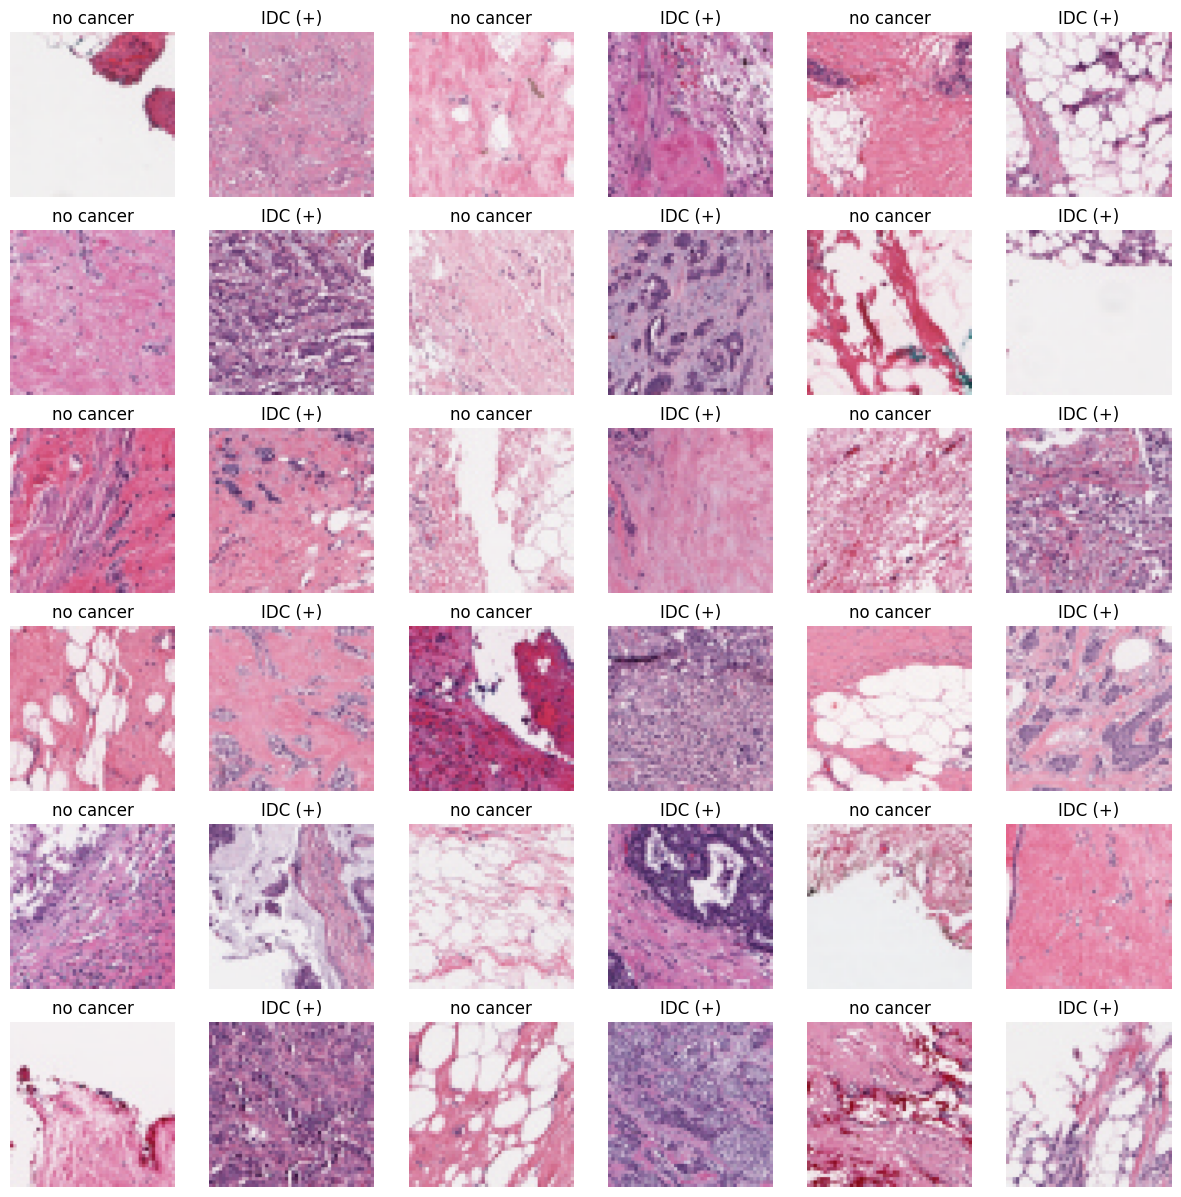

In [ ]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)

    elif img[-5] == '1' :
        P_IDC.append(img)
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:

        img = image.load_img((N_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)

        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:

        img = image.load_img((P_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)

        plt.subplot(6, 6, 2*s)
        plt.axis('off')
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1

In [ ]:
NewN_IDC=N_IDC[:78786]
print(len(NewN_IDC))
print(len(P_IDC))

78786
78786


**4TH STEP - DATA PRE-PROCESSING**

In [ ]:
non_img_arr = []
can_img_arr = []

for img in NewN_IDC:

    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])

for img in P_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

In [ ]:
print(len(non_img_arr))
print(len(can_img_arr))
print(len(non_img_arr)+len(can_img_arr))

78786
78786
157572


In [ ]:
X = []
y = []

# Assuming non_img_arr and can_img_arr are lists of tuples (feature, label)
breast_img_arr = non_img_arr[:12389] + can_img_arr[:12389]
random.shuffle(breast_img_arr)

for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)

X = np.array(X)
y = np.array(y)


In [ ]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,y)

Total number of images: 24778
Number of IDC(-) Images: 12389
Number of IDC(+) Images: 12389
Image shape (Width, Height, Channels): (50, 50, 3)


**5TH STEP - SPLIT THE DATASET INTO TRAIN & TEST DATA**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)

from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (17344, 50, 50, 3)
Testing Data Shape: (7434, 50, 50, 3)


**6TH STEP - CREATION OF A CNN MODEL**

In [ ]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
early_stop=EarlyStopping(monitor='val_loss',patience=5)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 50, 50, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 32)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 25, 25, 32)        128       
 chNormalization)                                                
                                                        

**7TH STEP - TRAINING OF THE CNN MODEL**

In [ ]:
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 10, batch_size = 35)

Epoch 1/10
496/496 [==============================] - 335s 666ms/step - loss: 0.5053 - accuracy: 0.7736 - val_loss: 0.4369 - val_accuracy: 0.8083
Epoch 2/10
496/496 [==============================] - 338s 682ms/step - loss: 0.4391 - accuracy: 0.8070 - val_loss: 0.4156 - val_accuracy: 0.8157
Epoch 3/10
496/496 [==============================] - 332s 669ms/step - loss: 0.4050 - accuracy: 0.8258 - val_loss: 0.4031 - val_accuracy: 0.8280
Epoch 4/10
496/496 [==============================] - 324s 653ms/step - loss: 0.3741 - accuracy: 0.8434 - val_loss: 0.3885 - val_accuracy: 0.8275
Epoch 5/10
496/496 [==============================] - 311s 628ms/step - loss: 0.3538 - accuracy: 0.8533 - val_loss: 0.3617 - val_accuracy: 0.8507
Epoch 6/10
496/496 [==============================] - 307s 619ms/step - loss: 0.3376 - accuracy: 0.8595 - val_loss: 0.3581 - val_accuracy: 0.8444
Epoch 7/10
496/496 [==============================] - 295s 596ms/step - loss: 0.3291 - accuracy: 0.8618 - val_loss: 0.3916 -

**8TH STEP - EVALUATION OF THE CNN MODEL**

In [ ]:
model.evaluate(X_test,Y_test)

233/233 [==============================] - 29s 124ms/step - loss: 0.3242 - accuracy: 0.8698


[0.32419759035110474, 0.8697874546051025]

**9TH STEP - GRAPHS OF THE RESULTS OBTAINED FROM THE MODEL TRAINING**

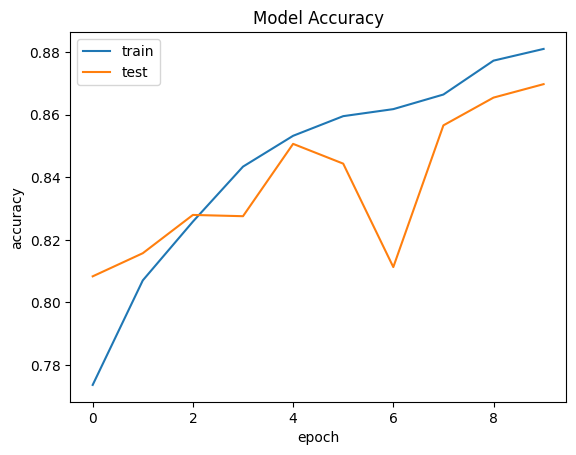

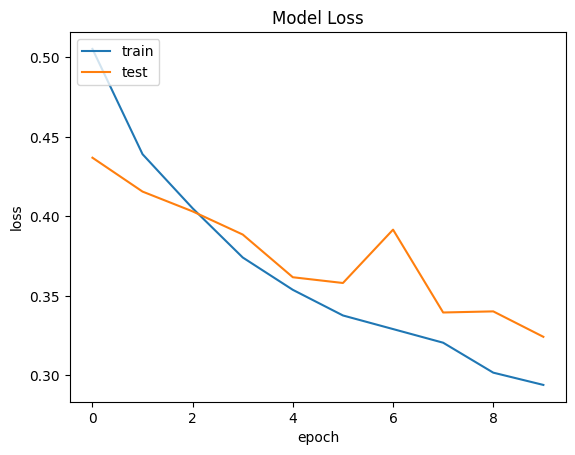

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**CONCLUSION**

Breast Cancer is a dangerous disease that has affected the life of many people all over the world. Scientists and researchers are still finding a way to permanently cure this life-threatening illness. In this new age technology where Artificial Intelligence and Machine Learning are used everywhere to solve complex problems this project also focuses on effective breast cancer classification with the help of machine learning particularly deep learning.We have used convolution neural networks to classify non cancerous and cancerous images.At the end we get a test accuracy as 86.98 for our CNN model.

**REFERENCES**

https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images

https://www.kaggle.com/

https://www.kaggle.com/code/thesnak/breast-cancer-classification-96-89